# Identifying Inland Water Bodies with Machine Learning
This notebook explores the use of unsupervised machine learning techniques to identify inland water bodies using high-resolution satellite imagery from the Sentinel-2 mission. Specifically, we apply the k-means clustering algorithm to perform pixel-based classification based on spectral reflectance.

To evaluate the method across diverse geographic and environmental conditions, two contrasting regions were selected for analysis. The first is Selin Lake, a large salt lake located on the Tibetan Plateau. This high-altitude region features mineral-rich waters and stark surrounding landscapes, offering a distinct spectral signature ideal for classification tests. The second study area is Finland's Lakeland region, known for its vast number of small, interconnected freshwater lakes and forested surroundings. Its complex shoreline geometry and varying water properties make it a suitable test case for assessing the robustness of unsupervised classification methods.

By comparing results across these two locations, we aim to understand how environmental variability affects the performance of unsupervised classification for inland water detection.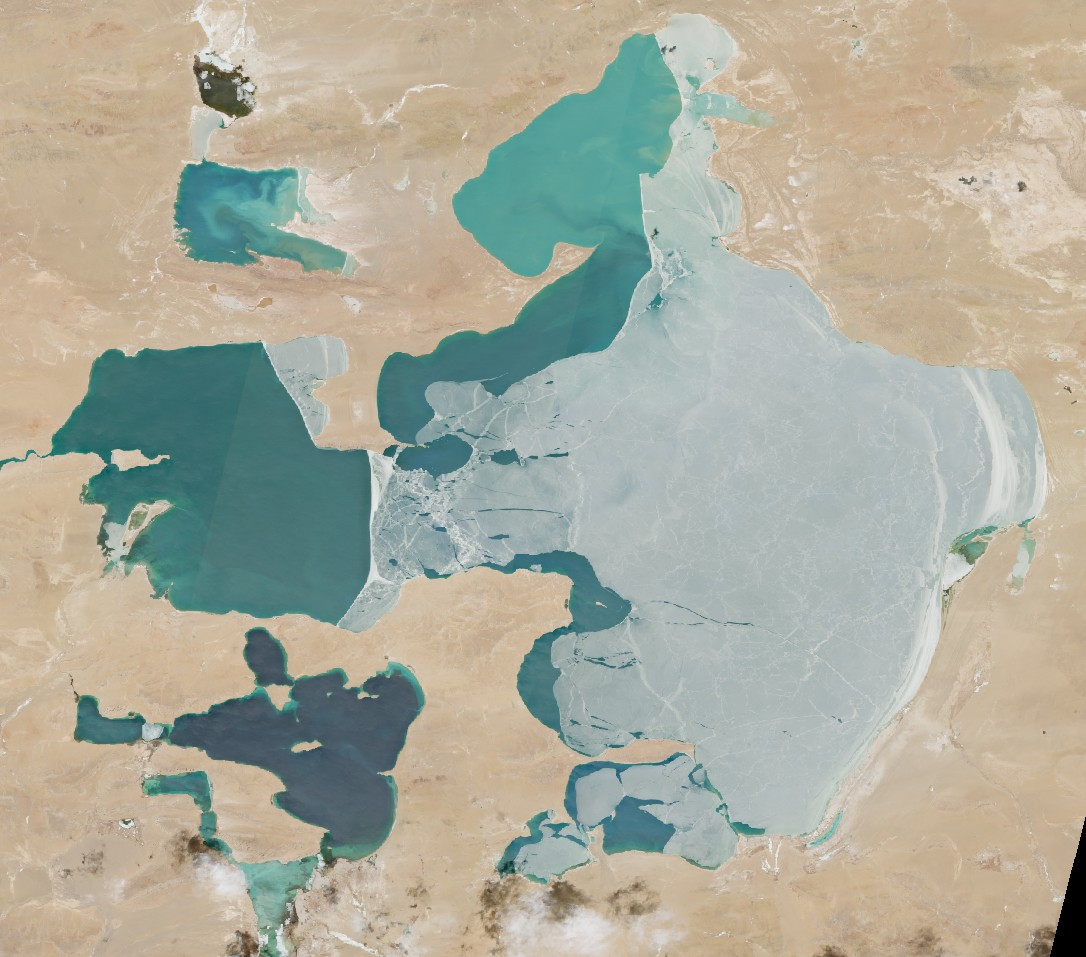
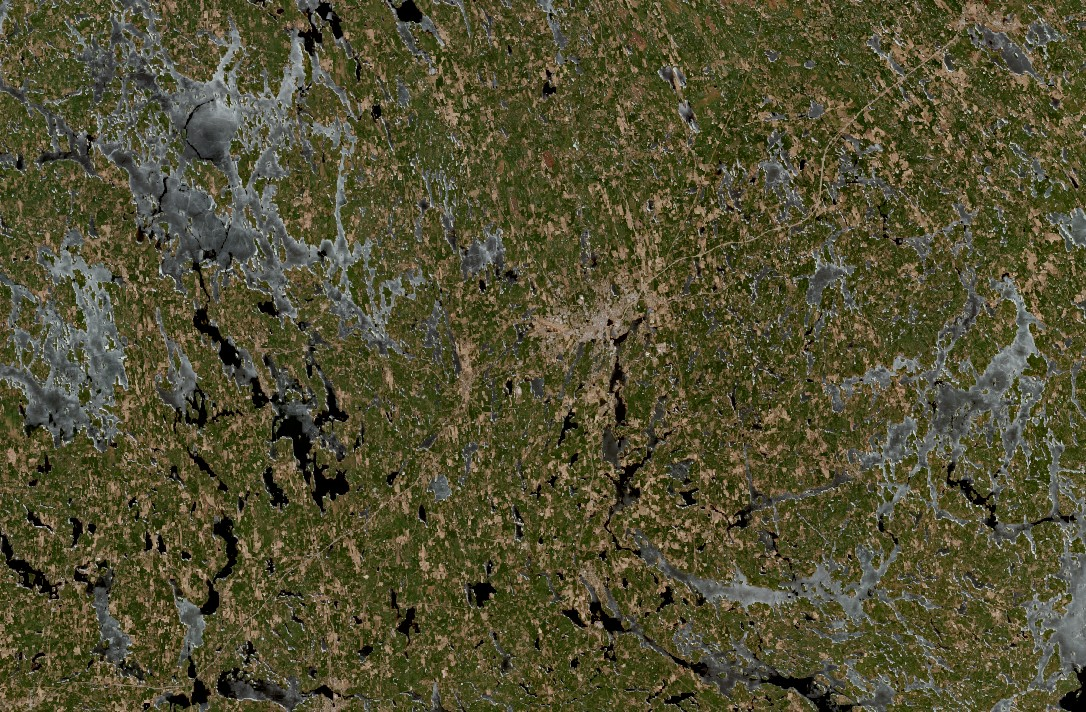

## Install Rasterio
Before executing the main parts of this notebook, we need to install rasterio. This Python package, which builds on GDAL and NumPy, is essential for reading and handling satellite raster data such as that from Sentinel-2. Use the cell below to install it if needed.

In [1]:
! pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 90.8 MB/s eta 0:00:00


The root file paths for the datasets used in this project are defined below and will be referenced throughout the notebook. Please ensure these paths reflect the directory structure on your own system.

Note that any filenames mentioned in the code are specific to the original datasets and should be updated accordingly if you're working with different regions or sources.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Specify file paths to the bands being used for Selin Lake region.
gl_base_path = "/content/drive/MyDrive/GEOL0069/Project/S2A_MSIL2A_20250528T045241_N0511_R076_T45SXR_20250528T080601.SAFE/GRANULE/L2A_T45SXR_A051868_20250528T045714/IMG_DATA"

# Specify file paths to the bands being used for Finland Lake District region
m_base_path = "/content/drive/MyDrive/GEOL0069/Project/S2C_MSIL1C_20250526T095051_N0511_R079_T35VNJ_20250526T132942.SAFE/GRANULE/L1C_T35VNJ_A003767_20250526T095047/IMG_DATA"

## Selin Lake
We begin by importing the necessary Sentinel-2 bands (B03 and B08) for the selected region. Using these, we compute the Normalized Difference Water Index (NDWI) based on the standard formula. A threshold is then applied to generate a binary water mask, where water pixels are labeled as 1 and non-water pixels as 0.

In [4]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
gl_bands_paths = {
    'B8': gl_base_path + '/R10m/T45SXR_20250528T045241_B08_10m.jp2',
    'B3': gl_base_path + '/R10m/T45SXR_20250528T045241_B03_10m.jp2',
}

# Read and stack the band images
gl_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(gl_bands_paths[band]) as src:
        gl_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
gl_band_stack = np.dstack(gl_band_data)
gl_valid_data_mask = np.all(gl_band_stack > 0, axis=2)


# Calculating the NDWI
gl_green_band = gl_band_stack[:,:,0].astype(np.float16)
gl_nir_band = gl_band_stack[:,:,1].astype(np.float16)

gl_ndwi = (gl_green_band-gl_nir_band)/(gl_green_band+gl_nir_band)

# Thresholding the NDWI
threshold = 0.0 # Threshold value
gl_mask_ndwi = np.where(gl_ndwi > threshold, 1, 0).astype(np.uint8)

Plotting the mask

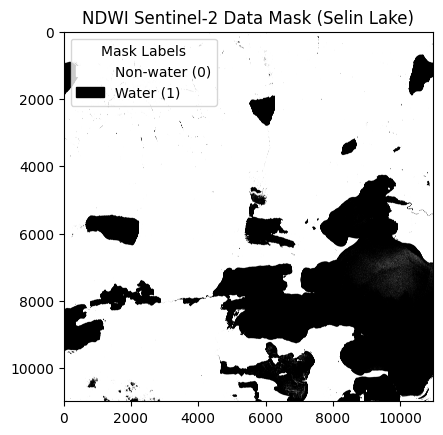

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')


# Plotting the result
plt.imshow(gl_mask_ndwi, cmap='binary')
plt.title('NDWI Sentinel-2 Data Mask (Selin Lake)')
plt.show()

## Finland Lake District
Same as Selin Lake.

In [6]:
import rasterio
import numpy as np

# Specify file paths to the bands being used
m_bands_paths = {
    'B8': m_base_path + '/T35VNJ_20250526T095051_B08.jp2',
    'B3': m_base_path + '/T35VNJ_20250526T095051_B03.jp2',
}

# Read and stack the band images
m_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(m_bands_paths[band]) as src:
        m_band_data.append(src.read(1))

# Stack bands
m_band_stack = np.dstack(m_band_data)


# Calculating the NDWI
m_green_band = m_band_stack[:,:,0].astype(np.float16)
m_nir_band = m_band_stack[:,:,1].astype(np.float16)

m_ndwi = (m_green_band-m_nir_band)/(m_green_band+m_nir_band)

# Thresholding the NDWI
threshold = 0.0 # Threshold value
m_mask_ndwi = np.where(m_ndwi > threshold, 1, 0).astype(np.uint8)

<ipython-input-6-7192762bdc70>:24: RuntimeWarning: invalid value encountered in divide
  m_ndwi = (m_green_band-m_nir_band)/(m_green_band+m_nir_band)


Plotting the mask

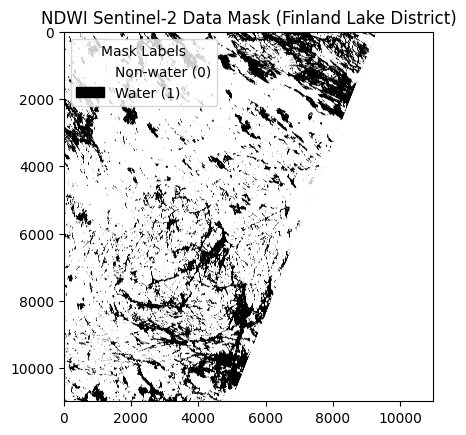

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.binary(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Plotting the result
plt.imshow(m_mask_ndwi, cmap='binary')
plt.title('NDWI Sentinel-2 Data Mask (Finland Lake District)')
plt.show()

## K-means Clustering for Water Body Detection
K-means clustering is a versatile unsupervised learning algorithm, particularly effective when the underlying structure of the data is unknown. Since it doesn't require labeled data or prior knowledge, it's well-suited for exploratory analysis—making it a strong candidate for identifying inland water bodies from satellite imagery.

## Study Areas: Selin Lake (Tibet) and the Finnish Lake District
This project focuses on two distinct regions: Selin Co, a large inland lake on the Tibetan Plateau, and the Finnish Lake District, known for its high density of small and medium-sized lakes. Each region is analyzed using two sets of Sentinel-2 bands—one set corresponding to NDWI, and the other inspired by alternative water indices such as the SWI.

## NDWI Bands: B03 and B08
For the first clustering approach, we use Band 3 (Green) and Band 8 (Near Infrared) from Sentinel-2, both at a 10-meter spatial resolution. These bands are commonly used in the Normalized Difference Water Index (NDWI) to distinguish between water and non-water surfaces.

Instead of computing the NDWI directly, we apply K-means clustering to the same bands to assess whether this machine learning method can outperform simple threshold-based techniques.

## Data Preparation
The code below reads in the selected bands and prepares them in a format suitable for clustering. The band data is stacked, validated, and processed into a usable input for the K-means algorithm.

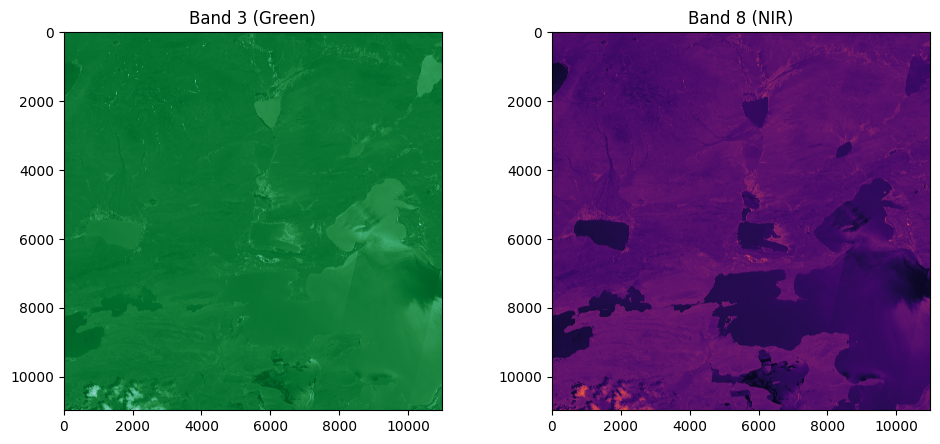

In [8]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Specify file paths to the bands being used
gl_bands_paths = {
    'B8': gl_base_path + '/R10m/T45SXR_20250528T045241_B08_10m.jp2',
    'B3': gl_base_path + '/R10m/T45SXR_20250528T045241_B03_10m.jp2',
}

# Read and stack the band images
gl_band_data = []
for band in ['B3', 'B8']:
    with rasterio.open(gl_bands_paths[band]) as src:
        gl_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
gl_band_stack = np.dstack(gl_band_data)
gl_valid_data_mask = np.all(gl_band_stack > 0, axis=2)

# Visual Plot of Bands

fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(gl_band_stack[:,:,0], cmap='BuGn_r')  # Plot on the first subplot (ax1)
ax1.set_title('Band 3 (Green)')

ax2.imshow(gl_band_stack[:,:,1], cmap= 'inferno')  # Plot on the second subplot (ax2)
ax2.set_title('Band 8 (NIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

The K-means algorithm is calculated below. Two clusters are used to fit the data.

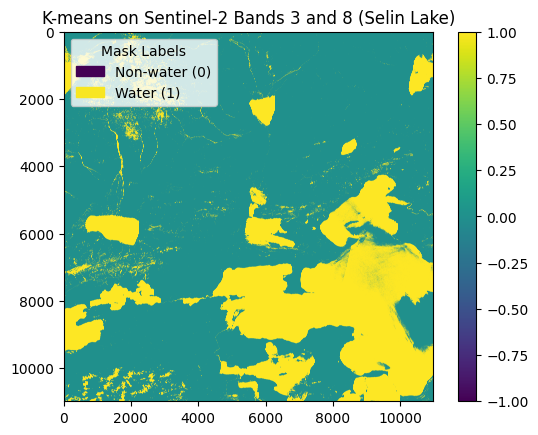

In [9]:
# Reshape for K-means, only including valid data
gl_X = gl_band_stack[gl_valid_data_mask].reshape((-1, 2))

# K-means clustering
gl_kmeans = KMeans(n_clusters=2, random_state=0).fit(gl_X)
gl_labels = gl_kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
gl_labels_image_traditional = np.full(gl_band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
gl_labels_image_traditional[gl_valid_data_mask] = gl_labels

# Plotting the result
# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Displaying Image
plt.imshow(gl_labels_image_traditional, cmap='viridis')
plt.title('K-means on Sentinel-2 Bands 3 and 8 (Selin Lake)')
plt.colorbar()
plt.show()

## Sentinel-2 SWI Bands: B05 and B11
In this approach, Band 5 (Vegetation Red Edge) and Band 11 (Short-Wave Infrared, SWIR) from Sentinel-2 are used as inputs for the K-means clustering algorithm. Both bands are provided at a 20-meter resolution.

These specific bands were highlighted in a 2020 study by Jiang et al., which introduced the Sentinel-2 Water Index (SWI). The SWI demonstrated superior accuracy in water body detection compared to the traditional NDWI by leveraging Sentinel-2’s unique spectral capabilities.

In this project, we incorporate B05 and B11 as an alternative feature set to evaluate how K-means performs when using bands derived from the SWI. This allows for a direct comparison between clustering results from NDWI-based and SWI-based spectral inputs.

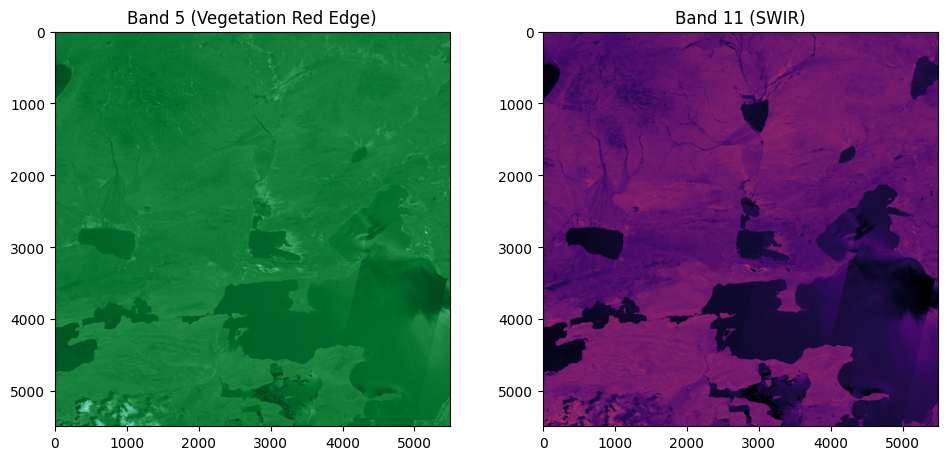

In [10]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Specify file paths to the bands being used
gl_bands_paths = {
    'B5': gl_base_path + '/R20m/T45SXR_20250528T045241_B05_20m.jp2',
    'B11': gl_base_path + '/R20m/T45SXR_20250528T045241_B11_20m.jp2'
}

# Read and stack the band images
gl_band_data = []
for band in ['B5', 'B11']:
    with rasterio.open(gl_bands_paths[band]) as src:
        gl_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
gl_band_stack = np.dstack(gl_band_data)
gl_valid_data_mask = np.all(gl_band_stack > 0, axis=2)

# Visualisation of bands being used
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(gl_band_stack[:,:,0], cmap='BuGn_r')  # Plot on the first subplot (ax1)
ax1.set_title('Band 5 (Vegetation Red Edge)')

ax2.imshow(gl_band_stack[:,:,1], cmap= 'inferno')  # Plot on the second subplot (ax2)
ax2.set_title('Band 11 (SWIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

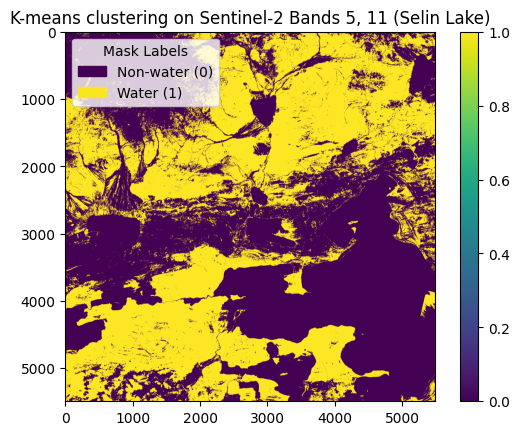

In [11]:
# Reshape for K-means, only including valid data
gl_X = gl_band_stack[gl_valid_data_mask].reshape((-1, 2))

# K-means clustering
gl_kmeans = KMeans(n_clusters=3, random_state=0).fit(gl_X)
gl_labels = gl_kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
gl_labels_image_swi = np.full(gl_band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
gl_labels_image_swi[gl_valid_data_mask] = gl_labels

# Simplifying labels so that we only have water and non-water
gl_labels_image_swi_flattened = np.where(gl_labels_image_swi >= 1, 0, 1)


# Plotting the result
# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Displaying Image
plt.imshow(gl_labels_image_swi_flattened, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands 5, 11 (Selin Lake)')
plt.colorbar()
plt.show()

## Performance Assessment for the Selin Lake Region
To assess how well the machine learning methods perform relative to the traditional NDWI approach, we utilize a confusion matrix. It’s important to note that this evaluation focuses on how closely the machine learning output aligns with NDWI-based classification, not on the absolute accuracy of water body boundaries. A more comprehensive assessment would require visual validation or comparison with ground-truth labels.

## Comparison of NDWI-Derived Bands
A visual comparison of the water masks generated by NDWI and k-means is presented below, enabling a qualitative assessment of their differences and similarities.



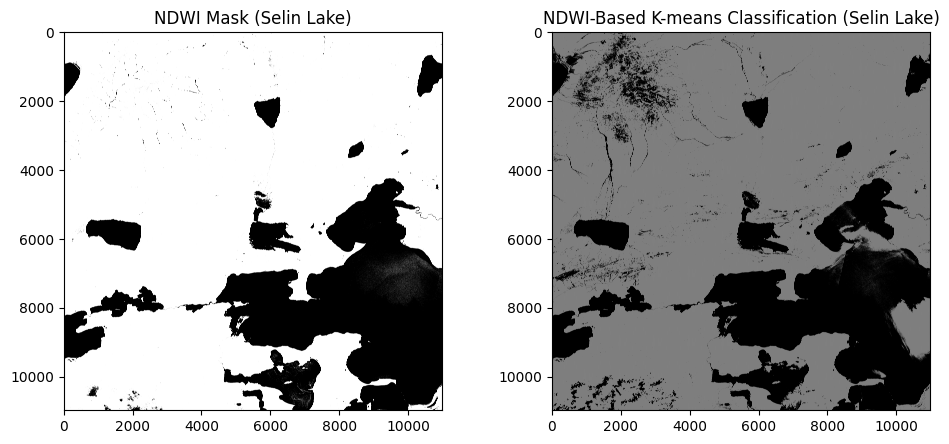

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(gl_mask_ndwi, cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('NDWI Mask (Selin Lake)')

ax2.imshow(gl_labels_image_traditional, cmap= 'binary')  # Plot on the second subplot (ax2)
ax2.set_title('NDWI-Based K-means Classification (Selin Lake)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

Calculation of confusion matrix.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.97      0.96      0.96  91149020
           1       0.87      0.90      0.89  29411380

    accuracy                           0.94 120560400
   macro avg       0.61      0.62      0.62 120560400
weighted avg       0.94      0.94      0.94 120560400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


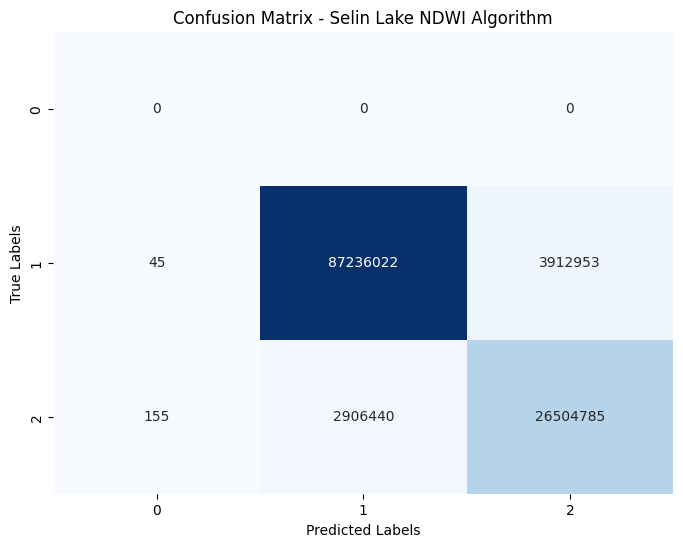

Accuracy: 0.94


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
mask_ndwi = gl_mask_ndwi

# Retrieval of values from K-means mask (1 = water, 0 = land)
kmeans_results = gl_labels_image_traditional

## Analysis calculations ##

# Flatten the 2D arrays
ndwi_baseline = mask_ndwi.flatten()
kmeans_pred = kmeans_results.flatten()

# Compute confusion matrix
cm = confusion_matrix(ndwi_baseline, kmeans_pred)

# Calculate accuracy
accuracy = accuracy_score(ndwi_baseline, kmeans_pred)

# Display classification report
report = classification_report(ndwi_baseline, kmeans_pred)
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Selin Lake NDWI Algorithm")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")

## SWI Evaluation
Side by side comparison of the two masks for visual reference:

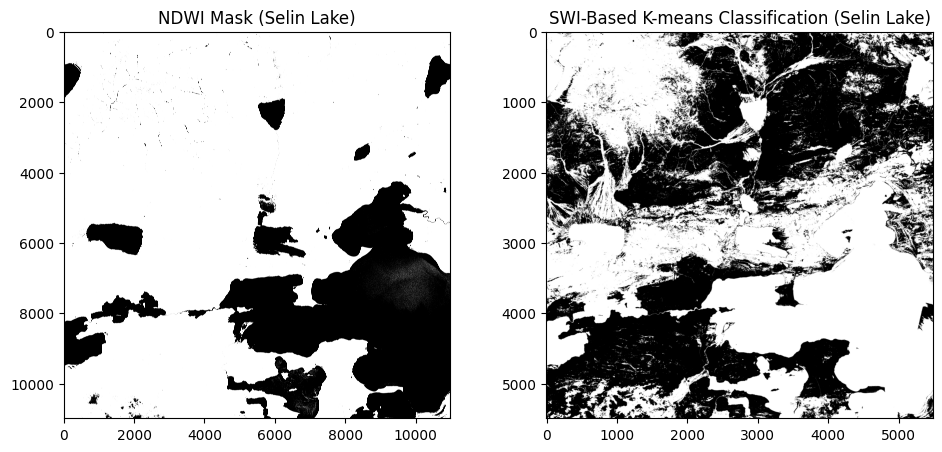

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(gl_mask_ndwi, cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('NDWI Mask (Selin Lake)')

ax2.imshow(gl_labels_image_swi_flattened, cmap= 'binary')  # Plot on the second subplot (ax2)
ax2.set_title('SWI-Based K-means Classification (Selin Lake)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

Calculation of confusion matrix.

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.41      0.48  22727534
           1       0.01      0.01      0.01   7412566

    accuracy                           0.32  30140100
   macro avg       0.28      0.21      0.24  30140100
weighted avg       0.43      0.32      0.36  30140100



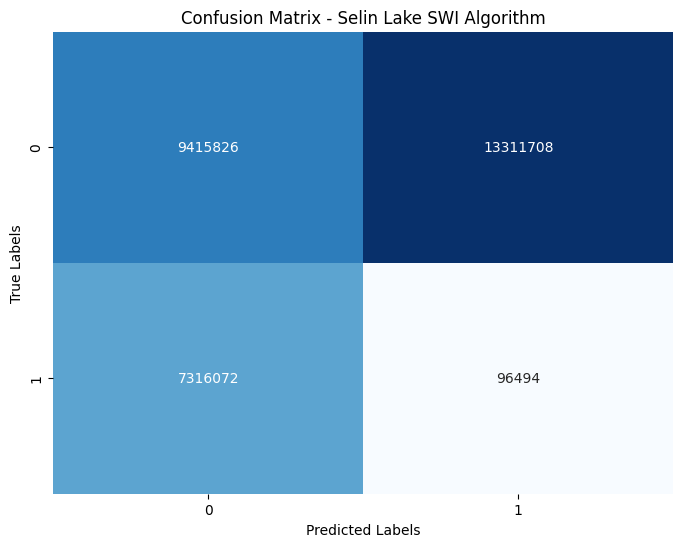

Accuracy: 0.32


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
mask_ndwi_resized = cv2.resize(gl_mask_ndwi, dsize=(5490, 5490))

# Retrieval of values from K-means mask (0 = water, 1 = land) -- values must be flipped
kmeans_results = gl_labels_image_swi_flattened

## Analysis calculations ##

# Flatten the 2D arrays
ndwi_baseline = mask_ndwi_resized.flatten()
kmeans_pred = kmeans_results.flatten()

# Compute confusion matrix
cm = confusion_matrix(ndwi_baseline, kmeans_pred)

# Calculate accuracy
accuracy = accuracy_score(ndwi_baseline, kmeans_pred)

# Display classification report
report = classification_report(ndwi_baseline, kmeans_pred)
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Selin Lake SWI Algorithm")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")

## Finland Lake District Analysis
Beyond the Selin Lake, we also apply the SWI-based K-means classification to the Finlan Lake District. Due to the high sediment content in its waters, this region often presents challenges for traditional indices like NDWI. By using the spectral bands associated with the SWI, we hypothesize that water bodies can be more accurately distinguished from surrounding land and sediment-heavy areas.

Below, the relevant satellite bands are loaded and prepared for analysis.

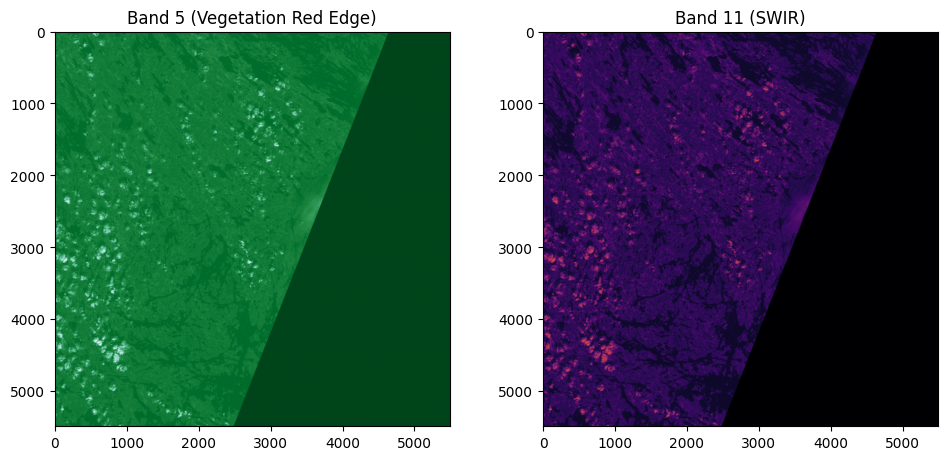

In [16]:
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Specify file paths to the bands being used
m_bands_paths = {
    'B5': m_base_path + '/T35VNJ_20250526T095051_B05.jp2',
    'B11': m_base_path + '/T35VNJ_20250526T095051_B11.jp2',
}

# Read and stack the band images
m_band_data = []
for band in ['B5', 'B11']:
    with rasterio.open(m_bands_paths[band]) as src:
        m_band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
m_band_stack = np.dstack(m_band_data)
m_valid_data_mask = np.all(m_band_stack > 0, axis=2)

# Visual representation of bands
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(m_band_stack[:,:,0], cmap='BuGn_r')  # Plot on the first subplot (ax1)
ax1.set_title('Band 5 (Vegetation Red Edge)')

ax2.imshow(m_band_stack[:,:,1], cmap= 'inferno')  # Plot on the second subplot (ax2)
ax2.set_title('Band 11 (SWIR)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

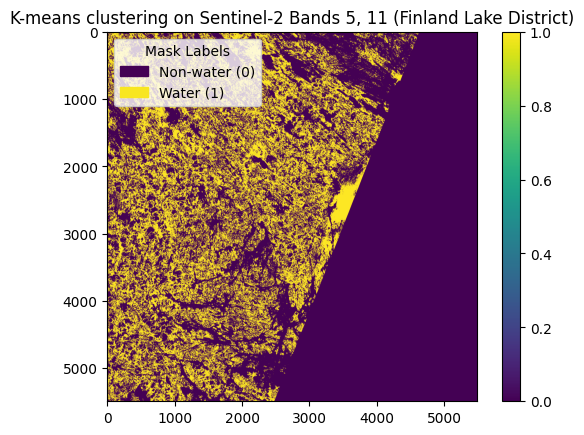

In [17]:
# Reshape for K-means, only including valid data
m_X = m_band_stack[m_valid_data_mask].reshape((-1, 2))

# K-means clustering
m_kmeans = KMeans(n_clusters=3, random_state=0).fit(m_X)
m_labels = m_kmeans.labels_

# Create an empty array for the result, filled with a no-data value (e.g., -1)
m_labels_image_swi = np.full(m_band_stack.shape[:2], -1, dtype=int)

# Place cluster labels in the locations corresponding to valid data
m_labels_image_swi[m_valid_data_mask] = m_labels

# Simplifying labels so that we only have water and non-water
m_labels_image_swi_flattened = np.where(m_labels_image_swi != 0, 0, 1)

# Plotting the result
# Create legend
patches = [
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0)),  # Patch for color at vmin
    Rectangle((0, 0), 1, 1, color=plt.cm.viridis(0.99)),  # Patch for color at vmax
]
labels = ['Non-water (0)', 'Water (1)']
plt.legend(patches, labels, loc='upper left', title='Mask Labels')

# Displaying image
plt.imshow(m_labels_image_swi_flattened, cmap='viridis')
plt.title('K-means clustering on Sentinel-2 Bands 5, 11 (Finland Lake District)')
plt.colorbar()
plt.show()

## Finland Lake District Performance Analysis
Same as Selin Lake.

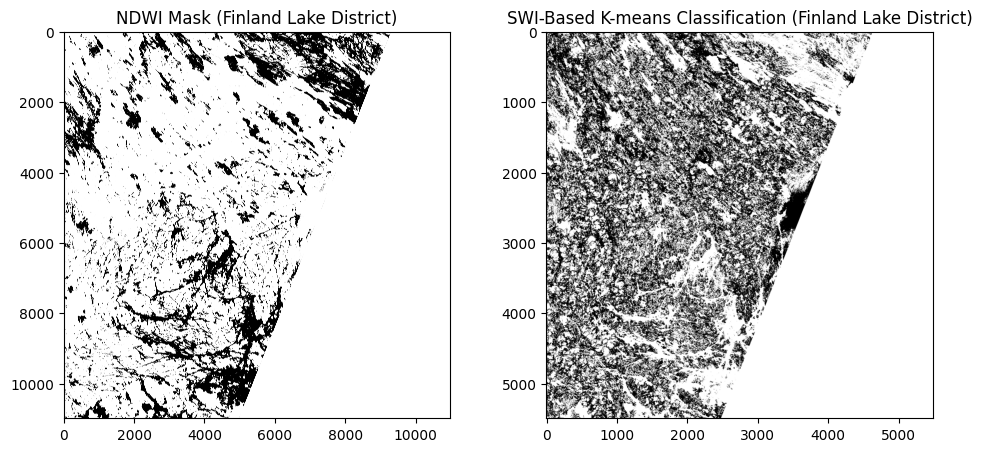

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(m_mask_ndwi, cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('NDWI Mask (Finland Lake District)')

ax2.imshow(m_labels_image_swi_flattened, cmap= 'binary')  # Plot on the second subplot (ax2)
ax2.set_title('SWI-Based K-means Classification (Finland Lake District)')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.67      0.73  25864307
           1       0.00      0.00      0.00   4275793

    accuracy                           0.58  30140100
   macro avg       0.40      0.34      0.37  30140100
weighted avg       0.69      0.58      0.63  30140100



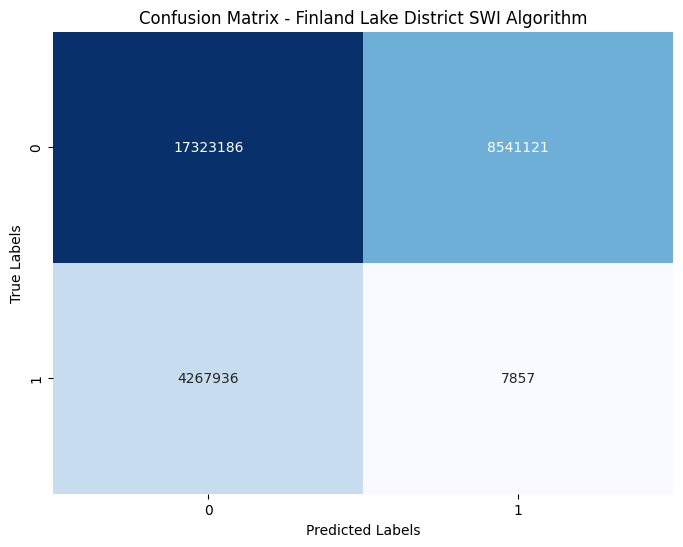

Accuracy: 0.58


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import cv2

## Data preprocessing ##

# Retrieval of values from NDWI mask (1 = water, 0 = land)
mask_ndwi_resized = cv2.resize(m_mask_ndwi, dsize=(5490, 5490))

# Retrieval of values from K-means mask (0 = water, 1 = land) -- values must be flipped
kmeans_results = m_labels_image_swi_flattened

## Analysis calculations ##

# Flatten the 2D arrays
ndwi_baseline = mask_ndwi_resized.flatten()
kmeans_pred = kmeans_results.flatten()

# Compute confusion matrix
cm = confusion_matrix(ndwi_baseline, kmeans_pred)

# Calculate accuracy
accuracy = accuracy_score(ndwi_baseline, kmeans_pred)

# Display classification report
report = classification_report(ndwi_baseline, kmeans_pred)
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Finland Lake District SWI Algorithm")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display accuracy
print(f"Accuracy: {accuracy:.2f}")

## Conclusion
The results indicate that K-means clustering performs comparably to the NDWI across both the Selin Lake Lake and Finland Lake District. This suggests that unsupervised learning approaches can serve as viable alternatives to traditional water indices. However, visual inspection reveals that K-means can outperform NDWI in certain challenging conditions.

 In contrast, the SWI-based K-means classification more accurately identifies these water bodies. A close-up view of the classification output highlights this difference — sediment-rich water that appears streaked or fragmented in the NDWI mask is correctly identified as water by the K-means approach.

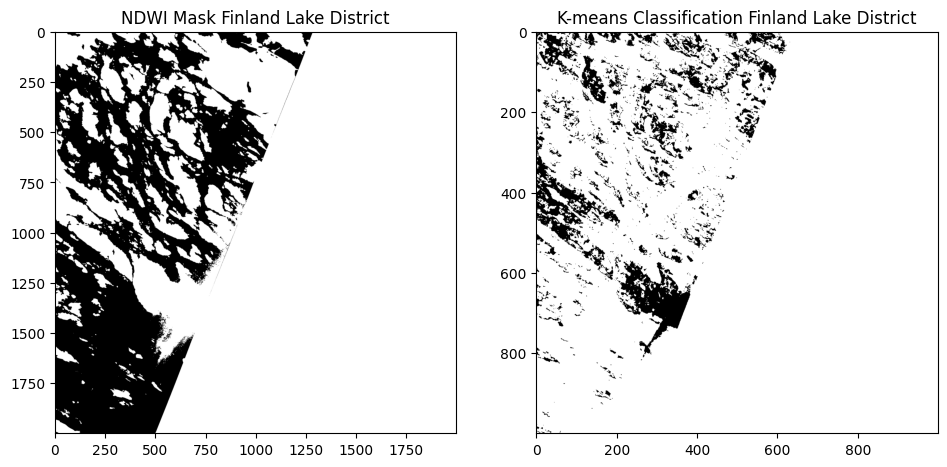

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)  # 1 row, 2 columns

ax1.imshow(m_mask_ndwi[0:2000, 8000:10000], cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('NDWI Mask Finland Lake District')

ax2.imshow(m_labels_image_swi_flattened[0:1000, 4000:5000], cmap= 'binary')  # Plot on the second subplot (ax2)
ax2.set_title('K-means Classification Finland Lake District')

plt.tight_layout()
fig.set_size_inches(10, 5)
plt.show()

A true-colour image can be generated from the RGB bands of the Finland Lake District dataset to visually compare the effectiveness of the classification masks.

In [21]:
# Image Quality Adjustment Function

max_r = 3.0 #3.0  # Max reflectance
mid_r = 0.13 # 0.13
sat = 2.0 # 1.2
gamma = 5 # 1.8
scalefac = 10000


def evaluate_pixel(smp):
  """
  Processes a single pixel based on provided bands.
  """
  rgb_lin = sat_enh(s_adj(smp[:,:,0]/scalefac), s_adj(smp[:,:,1]/scalefac), s_adj(smp[:,:,2]/scalefac))
  # rgb_lin = sat_enh((smp[:,:,0]/scalefac), (smp[:,:,1]/scalefac), (smp[:,:,2]/scalefac))
  # return rgb_lin
  return [s_rgb(rgb_lin[0]), s_rgb(rgb_lin[1]), s_rgb(rgb_lin[2])]

def s_adj(a):
  """
  Applies gamma adjustment after contrast enhancement.
  """
  return adj_gamma(adj(a, mid_r, 1, max_r))

g_off = 0.01
g_off_pow = g_off**gamma
g_off_range = (1 + g_off)**gamma - g_off_pow

def adj_gamma(b):
  """
  Applies gamma correction with offset.
  """
  return (b + g_off)**gamma - g_off_pow / g_off_range

# Saturation enhancement

def sat_enh(r, g, b):
  """
  Enhances saturation based on average value and factor.
  """
  avg_s = (r + g + b) / 3.0 * (1 - sat)
  return [clip(avg_s + r * sat), clip(avg_s + g * sat), clip(avg_s + b * sat)]

def clip(s):
  """
  Clips values to the range of 0 to 1.
  """
  s_1 = np.where(s > 1, 1, s)
  s_2 = np.where(s < 0, 0, s_1)
  return s_2

# Contrast enhancement with highlight compression

def adj(a, tx, ty, max_c):
  """
  Performs contrast enhancement with highlight compression.
  """
  ar = clip(a / max_c)
  return ar * (ar * (tx / max_c + ty - 1) - ty) / (ar * (2 * tx / max_c - 1) - tx / max_c)

def s_rgb(c):
  """
  Converts linear color value to sRGB equivalent.
  """
  return np.where(c <= 0.0031308, 12.92 * c, 1.055 * c**0.41666666666 - 0.055)


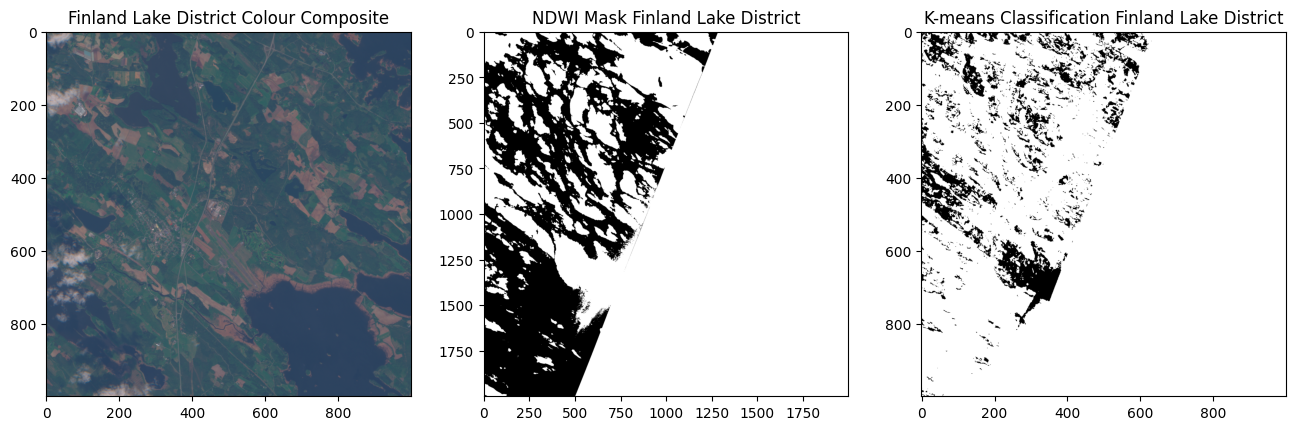

In [22]:
import rasterio
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

bands_paths = {
    'B2': m_base_path + '/T35VNJ_20250526T095051_B02.jp2',
    'B3': m_base_path + '/T35VNJ_20250526T095051_B03.jp2',
    'B4': m_base_path + '/T35VNJ_20250526T095051_B04.jp2'
}

# Read and stack the band images
band_data = []
for band in ['B4', 'B3', 'B2']:
    with rasterio.open(bands_paths[band]) as src:
        band_data.append(src.read(1))

# Stack bands and create a mask for valid data (non-zero values in all bands)
rgb_composite = np.dstack(band_data)

# Post-process image data
rgb_composite_new = np.dstack(evaluate_pixel(rgb_composite))


# Displaying Images

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)  # 1 row, 2 columns

ax1.imshow(rgb_composite_new[0:1000, 4000:5000, :], cmap='binary')  # Plot on the first subplot (ax1)
ax1.set_title('Finland Lake District Colour Composite')

ax2.imshow(m_mask_ndwi[0:2000, 8000:10000], cmap='binary')  # Plot on the first subplot (ax1)
ax2.set_title('NDWI Mask Finland Lake District')

ax3.imshow(m_labels_image_swi_flattened[0:1000, 4000:5000], cmap= 'binary')  # Plot on the second subplot (ax2)
ax3.set_title('K-means Classification Finland Lake District')

fig.set_size_inches(16, 15)
plt.show()